In [1]:
import numpy as np
from model_vanilla_zoom import DCGAN
from utils import pp, visualize, to_json, show_all_variables, expand_path, timestamp

import tensorflow as tf
import cv2
import time
import io
import IPython.display
import PIL.Image
import matplotlib.pyplot as plt

In [2]:
def imshow(a, im_size=256, format='png', jpeg_fallback=True, filename=None):
  if a.dtype != np.uint8:
      a = a*255
  a = np.asarray(a, dtype=np.uint8)
  a = cv2.resize(a, (a.shape[1], a.shape[0]))

  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

In [3]:
def imgrid(imarray, cols=5, pad=1):
  if imarray.dtype != np.uint8:
    raise ValueError('imgrid input imarray must be uint8')
  pad = int(pad)
  assert pad >= 0
  cols = int(cols)
  assert cols >= 1
  N, H, W, C = imarray.shape
  rows = int(np.ceil(N / float(cols)))
  batch_pad = rows * cols - N
  assert batch_pad >= 0
  post_pad = [batch_pad, pad, pad, 0]
  pad_arg = [[0, p] for p in post_pad]
  imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
  H += pad
  W += pad
  grid = (imarray
          .reshape(rows, cols, H, W, C)
          .transpose(0, 2, 1, 3, 4)
          .reshape(rows*H, cols*H, C))
  if pad:
    grid = grid[:-pad, :-pad]
  return grid

In [4]:
initializer = tf.global_variables_initializer()
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(initializer)

In [5]:
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

    print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))
        return not_initialized_vars

In [6]:
checkpoint_dir = "./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint"
sample_dir = "./out/zoom_NoAug_vanillaG_lr0.0002/sample"
num_samples = 10 # 1 sample per digit

flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_float("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", num_samples, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 28, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", 28, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 28, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", 28, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_boolean("aug", False, "True for enabling transformation augmentation")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("data_dir", "./data", "path to datasets [e.g. $HOME/data]")
flags.DEFINE_string("out_dir", "./out", "Root directory for outputs [e.g. $HOME/out]")
flags.DEFINE_string("out_name", "", "Folder (under out_root_dir) for all outputs. Generated automatically if left blank []")
# flags.DEFINE_string("checkpoint_dir", "checkpoint", "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
flags.DEFINE_string("checkpoint_dir", checkpoint_dir, "Folder (under out_root_dir/out_name) to save checkpoints [checkpoint]")
# flags.DEFINE_string("sample_dir", "samples", "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_string("sample_dir", sample_dir, "Folder (under out_root_dir/out_name) to save samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
flags.DEFINE_boolean("export", False, "True for exporting with new batch size")
flags.DEFINE_boolean("freeze", False, "True for exporting with new batch size")
flags.DEFINE_integer("max_to_keep", 1, "maximum number of checkpoints to keep")
flags.DEFINE_integer("sample_freq", 200, "sample every this many iterations")
flags.DEFINE_integer("ckpt_freq", 200, "save checkpoint every this many iterations")
flags.DEFINE_integer("z_dim", 100, "dimensions of z")
flags.DEFINE_integer("y_dim", 10, "choose dimensions of y to be 10")
flags.DEFINE_string("z_dist", "uniform_signed", "'normal01' or 'uniform_unsigned' or uniform_signed")
flags.DEFINE_boolean("G_img_sum", False, "Save generator image summaries in log")
#flags.DEFINE_integer("generate_test_images", 100, "Number of images to generate during test. [100]")
# only for jupyter:
flags.DEFINE_string('f', '', 'kernel')

FLAGS = flags.FLAGS

In [7]:
num_samples = FLAGS.batch_size # this is a bug, DCGAN.y placeholder is fixed to 64 but what if we want 1 sample?
dcgan = DCGAN(
    sess,
    input_width=FLAGS.input_width,
    input_height=FLAGS.input_height,
    output_width=FLAGS.output_width,
    output_height=FLAGS.output_height,
    batch_size=FLAGS.batch_size,
    sample_num=num_samples,
    y_dim=FLAGS.y_dim,
    z_dim=FLAGS.z_dim,
    dataset_name=FLAGS.dataset,
    aug=FLAGS.aug,    
    input_fname_pattern=FLAGS.input_fname_pattern,
    crop=FLAGS.crop,
    checkpoint_dir=FLAGS.checkpoint_dir,
    sample_dir=FLAGS.sample_dir,
    data_dir=FLAGS.data_dir,
    out_dir=FLAGS.out_dir,
    max_to_keep=FLAGS.max_to_keep)

load_success, load_counter = dcgan.load(FLAGS.checkpoint_dir)
if not load_success:
    raise Exception("Checkpoint not found in " + FLAGS.checkpoint_dir)

zoom aug is disabled
loading mnist without augmenting ...
 [*] Reading checkpoints... ./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint
INFO:tensorflow:Restoring parameters from ./out/zoom_NoAug_vanillaG_lr0.0002/checkpoint/model.b64-27200
 [*] Success to read model.b64-27200


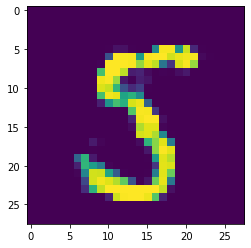

In [8]:
## Testing previously trained G
# visualize(sess, dcgan, FLAGS, 1, FLAGS.sample_dir)
z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

y = np.random.choice(FLAGS.y_dim, num_samples)
y_one_hot = np.zeros((num_samples, FLAGS.y_dim))
y_one_hot[np.arange(num_samples), y] = 1

samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
plt.imshow(samples[0,:,:,0])

In [9]:
## steerability walk
## define the graph
z_placeholder = tf.placeholder(tf.float32, [None, FLAGS.z_dim], name='z_sample')
y_placeholder = tf.placeholder(tf.float32, [None, FLAGS.y_dim], name='y_sample')

## this will go to get_target and then to the loss
outputs_orig = dcgan.my_sampler(z_placeholder, y_placeholder)

img_size = 28
Nsliders = 1
target = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
mask = tf.placeholder(tf.float32, shape=(None, img_size, img_size, Nsliders))
alpha = tf.placeholder(tf.float32, shape=None)
w = tf.Variable(np.random.uniform(-1, 1, [1, FLAGS.z_dim]), name='walk', dtype=np.float32)

z_new = z_placeholder-tf.log(alpha)*w
y_new = y_placeholder

## this is our transformed
transformed_output = dcgan.my_sampler(z_new, y_new)

loss = tf.losses.compute_weighted_loss(tf.square(transformed_output-target), weights=mask)
lr = 0.005
train_step = tf.train.AdamOptimizer(lr).minimize(loss, var_list=tf.trainable_variables(scope='walk'), 
                                                 name='AdamOpter')

## the graph already contains DCGAN and now we want to init the steerability part in it:
not_initialized_vars = initialize_uninitialized(sess)

['walk:0', 'beta1_power:0', 'beta2_power:0', 'walk/Adam:0', 'walk/Adam_1:0']


In [10]:
def get_target_np(outputs_zs, alpha, show_img=False, show_mask=False):
    
    mask_fn = np.ones(outputs_zs.shape)
    
    if alpha == 1:
        return outputs_zs, mask_fn
    
    new_size = int(alpha*img_size)

    ## crop
    if alpha < 1:
        output_cropped = outputs_zs[:,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
        mask_cropped = mask_fn
    ## padding
    else:
        output_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        mask_cropped = np.zeros((outputs_zs.shape[0], new_size, new_size, outputs_zs.shape[3]))
        output_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs 
        mask_cropped[:, new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn
    
    ## Resize
    target_fn = np.zeros(outputs_zs.shape)
    mask_out = np.zeros(outputs_zs.shape)
    for i in range(outputs_zs.shape[0]):
        target_fn[i,:,:,:] = np.expand_dims(cv2.resize(output_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        mask_out[i,:,:,:] = np.expand_dims(cv2.resize(mask_cropped[i,:,:,:], (img_size, img_size), interpolation = cv2.INTER_LINEAR), axis=2)
        
    mask_out[np.nonzero(mask_out)] = 1.
    assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)
    
    if show_img:
        print('Target image:')
        imshow_unscaled(target_fn)
    if show_mask:
        print('Target mask:')
        imshow_unscaled(mask_out)

    return target_fn, mask_out

In [11]:
# ! mkdir -p shift_l2_git/images
# ! mkdir -p shift_l2_git/output
import os
output_dir = './out/argminW/zoom_NoAug_l2_lr{}'.format(lr)
os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'output'), exist_ok=True)
saver = tf.train.Saver(tf.trainable_variables(scope=None))

In [12]:
# This can be train.py

import logging
import sys
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s",
    handlers=[
        logging.FileHandler("{0}/{1}.log".format(output_dir, 'train')),
        logging.StreamHandler(sys.stdout)
    ])
logger = logging.getLogger()

alpha_list = []
loss_vals = []

# train
train_sample_size = 20000
def train(saver):
    # init zs
    # we want couple of thousands per category, also compatible with batch_size
    num_samples = train_sample_size
    # sample inputs to feed to placeholders
    zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))

    # all categories
    y = np.random.choice(FLAGS.y_dim, num_samples)
    ys = np.zeros((num_samples, FLAGS.y_dim))
    ys[np.arange(num_samples), y] = 1

    Loss_sum = 0;
    n_epoch = 1
    optim_iter = 0
    batch_size = FLAGS.batch_size
    loss_values = []
    Loss_sum_iter = 0  
    
    for epoch in range(n_epoch):
        for batch_start in range(0, num_samples, batch_size):
            start_time = time.time()
            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(0.6, 1.) 
            else:
                alpha_val = np.random.uniform(1., 1.67) 

            s = slice(batch_start, min(num_samples, batch_start + batch_size))

            feed_dict_out = {z_placeholder: zs[s], y_placeholder: ys[s]}
            out_zs = sess.run(outputs_orig, feed_dict_out)
            
            target_fn, mask_out = get_target_np(out_zs, alpha_val)#, show_img=True, show_mask=True)

            feed_dict = {z_placeholder: zs[s], y_placeholder: ys[s], alpha: alpha_val, target: target_fn, mask: mask_out}
            curr_loss, _ = sess.run([loss, train_step], feed_dict=feed_dict)

            Loss_sum = Loss_sum + curr_loss
            Loss_sum_iter = Loss_sum_iter + curr_loss
            
            elapsed_time = time.time() - start_time

            logger.info('T, epc, bst, lss, a: {}, {}, {}, {}, {}'.format(elapsed_time, epoch, batch_start, curr_loss, alpha_val))

            alpha_list.append(alpha_val)

            if (optim_iter % 2500 == 0) and (optim_iter > 0):
                saver.save(style_sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)
            
            if (optim_iter % 100 == 0) and (optim_iter > 0):
                loss_vals.append(Loss_sum_iter/(100*batch_size))
                Loss_sum_iter = 0
                print('Loss:', loss_vals)

            optim_iter = optim_iter+1
            
    if optim_iter > 0:
        print('average loss with this metric: ', Loss_sum/(optim_iter*batch_size))
    saver.save(sess, '{}/{}/model_{}.ckpt'.format(output_dir, 'output', optim_iter*batch_size), write_meta_graph=False, write_state=False)

In [13]:
train(dcgan.saver)

2019-09-12 15:54:15,652 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.2810795307159424, 0, 0, 0.1890411525964737, 0.6472203579107133
2019-09-12 15:54:15,659 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006234884262084961, 0, 10, 0.13941769301891327, 1.3268087896318332
2019-09-12 15:54:15,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057523250579833984, 0, 20, 0.016815204173326492, 0.9815755022674948
2019-09-12 15:54:15,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007923364639282227, 0, 30, 0.23485061526298523, 0.6127145854473951
2019-09-12 15:54:15,683 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007313966751098633, 0, 40, 0.15551963448524475, 0.7252242541560228
2019-09-12 15:54:15,692 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008057117462158203, 0, 50, 0.14893554151058197, 1.4911149630515041
2019-09-12 15:54:15,702 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009275197982788086, 0, 60, 0.01791008561849594, 1.044392562618181
2019-09-12 15:54:15,710 [MainThread  

2019-09-12 15:54:16,098 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005873203277587891, 0, 600, 0.15484359860420227, 0.7805792434199624
2019-09-12 15:54:16,104 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006026506423950195, 0, 610, 0.06601379066705704, 0.8725510782455248
2019-09-12 15:54:16,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005600452423095703, 0, 620, 0.16787928342819214, 0.7048058712112911
2019-09-12 15:54:16,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007805824279785156, 0, 630, 0.09439939260482788, 1.3044461411665558
2019-09-12 15:54:16,128 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0073299407958984375, 0, 640, 0.012524846009910107, 0.9858461789885951
2019-09-12 15:54:16,136 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007441520690917969, 0, 650, 0.03641968593001366, 1.1099296525861753
2019-09-12 15:54:16,144 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00728917121887207, 0, 660, 0.04324081912636757, 0.9138662271899038
2019-09-12 15:54:16,153 [M

2019-09-12 15:54:16,563 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007323265075683594, 0, 1190, 0.1855926513671875, 0.6494968020849599
2019-09-12 15:54:16,570 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005987882614135742, 0, 1200, 0.08775968849658966, 0.8209370522163353
2019-09-12 15:54:16,577 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067768096923828125, 0, 1210, 0.2242283672094345, 0.6233572929166648
2019-09-12 15:54:16,585 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006799936294555664, 0, 1220, 0.11802159249782562, 1.57419737016607
2019-09-12 15:54:16,592 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067729949951171875, 0, 1230, 0.11114324629306793, 1.6439670463345952
2019-09-12 15:54:16,600 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006964445114135742, 0, 1240, 0.2162388563156128, 0.6597351612040582
2019-09-12 15:54:16,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068590641021728516, 0, 1250, 0.04568622261285782, 1.2223871405048814
2019-09-12 15:54:16,61

2019-09-12 15:54:17,013 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005782127380371094, 0, 1780, 0.19143101572990417, 0.6825605947284662
2019-09-12 15:54:17,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005494117736816406, 0, 1790, 0.11956597119569778, 0.7670089646136529
2019-09-12 15:54:17,025 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005624055862426758, 0, 1800, 0.04999961704015732, 0.863003781286829
2019-09-12 15:54:17,032 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006025075912475586, 0, 1810, 0.07804697006940842, 1.2959312969680306
2019-09-12 15:54:17,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005536794662475586, 0, 1820, 0.09429777413606644, 1.5373217599270532
2019-09-12 15:54:17,044 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0055561065673828125, 0, 1830, 0.07960332185029984, 1.4848759173272734
2019-09-12 15:54:17,050 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005461931228637695, 0, 1840, 0.0003029088256880641, 1.0181279140914752
2019-09-12 15:54:1

2019-09-12 15:54:17,444 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007829427719116211, 0, 2370, 0.029154866933822632, 1.16062100529957
2019-09-12 15:54:17,451 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006037235260009766, 0, 2380, 0.13940216600894928, 0.7578807457782717
2019-09-12 15:54:17,458 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005757808685302734, 0, 2390, 0.0908169224858284, 0.8391025818442462
2019-09-12 15:54:17,464 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005754947662353516, 0, 2400, 0.138999342918396, 0.726242052127309
2019-09-12 15:54:17,472 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007387638092041016, 0, 2410, 0.08734236657619476, 1.5049889813230697
2019-09-12 15:54:17,484 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.010734081268310547, 0, 2420, 0.20818054676055908, 0.630782671093064
2019-09-12 15:54:17,497 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012388944625854492, 0, 2430, 0.18883517384529114, 0.6348548644030663
2019-09-12 15:54:17,504 [M

2019-09-12 15:54:17,893 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006992340087890625, 0, 2960, 0.06830944120883942, 1.300622902425551
2019-09-12 15:54:17,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006329059600830078, 0, 2970, 0.08256801217794418, 1.6279332821414385
2019-09-12 15:54:17,908 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0065174102783203125, 0, 2980, 0.03165414184331894, 1.21838684135215
2019-09-12 15:54:17,915 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006101131439208984, 0, 2990, 0.09035377204418182, 1.623472387401799
2019-09-12 15:54:17,922 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006566047668457031, 0, 3000, 0.08410411328077316, 1.4902756859984794
Loss: [0.009976278188813012, 0.008551103154662997, 0.007183376063252126]
2019-09-12 15:54:17,930 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006788492202758789, 0, 3010, 0.21647778153419495, 0.6823107083641203
2019-09-12 15:54:17,937 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006500720977783203,

2019-09-12 15:54:18,338 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006997346878051758, 0, 3550, 0.0002691065310500562, 1.0110567285457048
2019-09-12 15:54:18,346 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007562160491943359, 0, 3560, 0.06443912535905838, 1.331762254980815
2019-09-12 15:54:18,355 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007438182830810547, 0, 3570, 0.05638544633984566, 1.4392274630850426
2019-09-12 15:54:18,363 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006943702697753906, 0, 3580, 0.05511340871453285, 1.2621997278884716
2019-09-12 15:54:18,370 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00676274299621582, 0, 3590, 0.07441576570272446, 1.518592161030949
2019-09-12 15:54:18,378 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006629228591918945, 0, 3600, 0.07548248767852783, 1.4075108168474824
2019-09-12 15:54:18,386 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007093667984008789, 0, 3610, 0.15799970924854279, 0.7449700121582434
2019-09-12 15:54:18,3

2019-09-12 15:54:18,801 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007028341293334961, 0, 4130, 0.036962978541851044, 1.2196663370742467
2019-09-12 15:54:18,807 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0060231685638427734, 0, 4140, 0.07791978120803833, 1.50958987368152
2019-09-12 15:54:18,814 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006674766540527344, 0, 4150, 0.034908805042505264, 0.9267693137041914
2019-09-12 15:54:18,822 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006502866744995117, 0, 4160, 0.03486825153231621, 0.8697373174475573
2019-09-12 15:54:18,829 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006621360778808594, 0, 4170, 0.05812162160873413, 1.3353575594734355
2019-09-12 15:54:18,836 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005936861038208008, 0, 4180, 0.19327902793884277, 0.6413212387522038
2019-09-12 15:54:18,843 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00664830207824707, 0, 4190, 0.05675441026687622, 1.3462179584814777
2019-09-12 15:54:18,

2019-09-12 15:54:19,248 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00685882568359375, 0, 4720, 0.05658234655857086, 1.2791075600160946
2019-09-12 15:54:19,256 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006799459457397461, 0, 4730, 0.11072471737861633, 0.7495060251505183
2019-09-12 15:54:19,269 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.012179374694824219, 0, 4740, 0.09205356240272522, 0.7538428551147762
2019-09-12 15:54:19,276 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006745815277099609, 0, 4750, 0.10430146008729935, 1.6082168249793827
2019-09-12 15:54:19,283 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006698131561279297, 0, 4760, 0.05524345487356186, 1.3058729905928228
2019-09-12 15:54:19,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006985187530517578, 0, 4770, 0.07622513175010681, 1.6189340601552482
2019-09-12 15:54:19,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0067348480224609375, 0, 4780, 0.10011395066976547, 1.5729720063998287
2019-09-12 15:54:19,

2019-09-12 15:54:19,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005774259567260742, 0, 5300, 0.0019982270896434784, 1.0352541526873429
2019-09-12 15:54:19,681 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005588054656982422, 0, 5310, 0.11019714921712875, 0.7965791654267109
2019-09-12 15:54:19,688 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00552058219909668, 0, 5320, 0.010371210984885693, 1.099729477190416
2019-09-12 15:54:19,693 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005299091339111328, 0, 5330, 0.15308789908885956, 0.7725187349123739
2019-09-12 15:54:19,700 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00562596321105957, 0, 5340, 0.02578047476708889, 1.1306259671099168
2019-09-12 15:54:19,706 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005452156066894531, 0, 5350, 0.07259829342365265, 1.6011424843646798
2019-09-12 15:54:19,712 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005644559860229492, 0, 5360, 0.07215166836977005, 1.3022898694255645
2019-09-12 15:54:19,

2019-09-12 15:54:20,076 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005700111389160156, 0, 5890, 0.08485466241836548, 1.6511849298136427
2019-09-12 15:54:20,082 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005477190017700195, 0, 5900, 0.05053141713142395, 1.439909820549671
2019-09-12 15:54:20,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006641387939453125, 0, 5910, 0.03256794437766075, 1.155436207552026
2019-09-12 15:54:20,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.013248205184936523, 0, 5920, 0.019694283604621887, 1.0466410649925306
2019-09-12 15:54:20,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064618587493896484, 0, 5930, 0.01845524273812771, 0.9376869643370829
2019-09-12 15:54:20,118 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005938053131103516, 0, 5940, 0.054269708693027496, 1.259786461329175
2019-09-12 15:54:20,125 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006629228591918945, 0, 5950, 0.03174576908349991, 1.1254791507155084
2019-09-12 15:54:20,

2019-09-12 15:54:20,513 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007315635681152344, 0, 6470, 0.04820488020777702, 1.4332216275230771
2019-09-12 15:54:20,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069332122802734375, 0, 6480, 0.07525495439767838, 0.7947297858042965
2019-09-12 15:54:20,529 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006900310516357422, 0, 6490, 0.0002067413297481835, 1.009986570802101
2019-09-12 15:54:20,536 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006771087646484375, 0, 6500, 0.03946657106280327, 0.8767363013901726
2019-09-12 15:54:20,546 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008550405502319336, 0, 6510, 0.06939025968313217, 1.5694843625521
2019-09-12 15:54:20,554 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007642030715942383, 0, 6520, 0.07515951246023178, 1.599656567755265
2019-09-12 15:54:20,562 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006720066070556641, 0, 6530, 0.08078515529632568, 1.6271120236225443
2019-09-12 15:54:20,57

2019-09-12 15:54:20,956 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006036520004272461, 0, 7050, 0.05524750426411629, 0.9042901014647206
2019-09-12 15:54:20,964 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007350921630859375, 0, 7060, 0.08884813636541367, 1.4400602420542912
2019-09-12 15:54:20,972 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006627798080444336, 0, 7070, 0.08477059006690979, 1.6397496112952021
2019-09-12 15:54:20,978 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006020069122314453, 0, 7080, 0.048619311302900314, 0.8654320348059331
2019-09-12 15:54:20,985 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059888362884521484, 0, 7090, 0.050168104469776154, 1.3661225258117047
2019-09-12 15:54:20,993 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007908821105957031, 0, 7100, 0.05513511225581169, 1.3218611620435035
2019-09-12 15:54:21,003 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008955717086791992, 0, 7110, 0.16932441294193268, 0.7031876504337815
2019-09-12 15:54:

2019-09-12 15:54:21,488 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008009672164916992, 0, 7640, 0.027599480003118515, 1.1496917800406636
2019-09-12 15:54:21,496 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0074460506439208984, 0, 7650, 0.1095242127776146, 0.8176436577182535
2019-09-12 15:54:21,504 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007498264312744141, 0, 7660, 0.02446696162223816, 1.045182133875549
2019-09-12 15:54:21,512 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007178068161010742, 0, 7670, 0.08642047643661499, 1.5983437680326316
2019-09-12 15:54:21,521 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007162809371948242, 0, 7680, 0.009650473482906818, 1.0742806990110012
2019-09-12 15:54:21,529 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007085323333740234, 0, 7690, 0.06247618421912193, 0.8442204738231082
2019-09-12 15:54:21,537 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007559061050415039, 0, 7700, 0.08264444768428802, 1.6283518654256084
2019-09-12 15:54:21

2019-09-12 15:54:21,980 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007722139358520508, 0, 8220, 0.038577936589717865, 0.8706764093561998
2019-09-12 15:54:21,988 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007058382034301758, 0, 8230, 0.04633141681551933, 1.3020431451002523
2019-09-12 15:54:21,997 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008334636688232422, 0, 8240, 0.0795540064573288, 1.3276815964227655
2019-09-12 15:54:22,006 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007409095764160156, 0, 8250, 0.03036774881184101, 0.9233345894496787
2019-09-12 15:54:22,019 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01209259033203125, 0, 8260, 0.05018256977200508, 1.381567728196289
2019-09-12 15:54:22,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069539546966552734, 0, 8270, 0.04229726269841194, 0.8596843420013269
2019-09-12 15:54:22,038 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.01052713394165039, 0, 8280, 0.08675096184015274, 1.6630926294736406
2019-09-12 15:54:22,04

2019-09-12 15:54:22,493 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008610963821411133, 0, 8810, 0.12040291726589203, 0.7458513329699528
2019-09-12 15:54:22,502 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008099794387817383, 0, 8820, 0.0648549422621727, 1.3008978044298902
2019-09-12 15:54:22,511 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008037090301513672, 0, 8830, 0.09111106395721436, 0.8174550860824141
2019-09-12 15:54:22,520 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00817728042602539, 0, 8840, 0.01912970095872879, 1.1515749566211813
2019-09-12 15:54:22,529 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00830388069152832, 0, 8850, 0.04117356240749359, 1.2316800740019747
2019-09-12 15:54:22,540 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009566307067871094, 0, 8860, 0.015073824673891068, 0.959442323645465
2019-09-12 15:54:22,551 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009475231170654297, 0, 8870, 0.06913680583238602, 1.3997870787229059
2019-09-12 15:54:22,560

2019-09-12 15:54:23,027 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008063554763793945, 0, 9390, 0.010143262334167957, 1.081485016776088
2019-09-12 15:54:23,036 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008146047592163086, 0, 9400, 0.035225655883550644, 0.8699743867952445
2019-09-12 15:54:23,045 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008156061172485352, 0, 9410, 0.05066491290926933, 1.2637268898024692
2019-09-12 15:54:23,054 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007927894592285156, 0, 9420, 0.06330167502164841, 1.2925714109611066
2019-09-12 15:54:23,062 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007662773132324219, 0, 9430, 0.22962436079978943, 0.6971613560490484
2019-09-12 15:54:23,072 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008105754852294922, 0, 9440, 0.02598913200199604, 1.111183370625506
2019-09-12 15:54:23,081 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008669137954711914, 0, 9450, 0.06153732165694237, 1.2910321110057725
2019-09-12 15:54:23,

2019-09-12 15:54:23,563 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008703231811523438, 0, 9980, 0.03347691893577576, 0.9178056621467467
2019-09-12 15:54:23,572 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008188009262084961, 0, 9990, 0.0363028384745121, 1.1210947651218552
2019-09-12 15:54:23,581 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00824737548828125, 0, 10000, 0.016462311148643494, 1.1534027857656668
Loss: [0.009976278188813012, 0.008551103154662997, 0.007183376063252126, 0.008202704664610792, 0.007235169234241766, 0.008330182728357612, 0.007570643162296619, 0.0074852041247067975, 0.007196002898763254, 0.007055303443907178]
2019-09-12 15:54:23,590 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007727861404418945, 0, 10010, 0.19204072654247284, 0.7042576040210738
2019-09-12 15:54:23,599 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007959365844726562, 0, 10020, 0.11657068878412247, 0.7243878751957261
2019-09-12 15:54:23,608 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0

2019-09-12 15:54:24,079 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006976127624511719, 0, 10550, 0.024716448038816452, 1.142545148554237
2019-09-12 15:54:24,087 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068569183349609375, 0, 10560, 0.012744669802486897, 0.9602739769981945
2019-09-12 15:54:24,095 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0070989131927490234, 0, 10570, 0.012966439127922058, 0.9764458001906086
2019-09-12 15:54:24,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007268190383911133, 0, 10580, 0.04140191525220871, 0.9125847798656714
2019-09-12 15:54:24,111 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007509946823120117, 0, 10590, 0.0889228880405426, 0.7978889537759879
2019-09-12 15:54:24,120 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00791311264038086, 0, 10600, 0.18196731805801392, 0.7118446769699545
2019-09-12 15:54:24,128 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007588386535644531, 0, 10610, 0.05403581261634827, 1.3417565889777259
2019-09-12 

2019-09-12 15:54:24,607 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007654428482055664, 0, 11120, 0.09103009104728699, 1.639533620874251
2019-09-12 15:54:24,617 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0082855224609375, 0, 11130, 0.04178371652960777, 1.2404174397464107
2019-09-12 15:54:24,626 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008253335952758789, 0, 11140, 0.06795395165681839, 1.4842022466914495
2019-09-12 15:54:24,635 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008228778839111328, 0, 11150, 0.040963031351566315, 1.2370667132687552
2019-09-12 15:54:24,644 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00814676284790039, 0, 11160, 0.06125355884432793, 0.850165034291215
2019-09-12 15:54:24,654 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008498430252075195, 0, 11170, 0.09922216832637787, 0.755320057847251
2019-09-12 15:54:24,663 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008137226104736328, 0, 11180, 0.04691719636321068, 1.5348622985793225
2019-09-12 15:54:2

2019-09-12 15:54:25,169 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007403373718261719, 0, 11710, 0.07258216291666031, 1.5901898844087032
2019-09-12 15:54:25,177 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068624019622802734, 0, 11720, 0.10573041439056396, 0.728022805119088
2019-09-12 15:54:25,185 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006516218185424805, 0, 11730, 0.08231885731220245, 1.607413813069246
2019-09-12 15:54:25,192 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0063555240631103516, 0, 11740, 0.04363710805773735, 1.286940804026792
2019-09-12 15:54:25,199 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0064771175384521484, 0, 11750, 0.010758594609797001, 0.9561674697426542
2019-09-12 15:54:25,206 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006341457366943359, 0, 11760, 0.042992640286684036, 0.8966629570182516
2019-09-12 15:54:25,213 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006453037261962891, 0, 11770, 0.07229410111904144, 1.6007760230282106
2019-09-12 

2019-09-12 15:54:25,622 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006871461868286133, 0, 12280, 0.014455242082476616, 0.9873316324262
2019-09-12 15:54:25,631 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007873296737670898, 0, 12290, 0.07394086569547653, 1.5513577284155557
2019-09-12 15:54:25,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009734392166137695, 0, 12300, 0.0012706078123301268, 1.0295601728481687
2019-09-12 15:54:25,648 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006242990493774414, 0, 12310, 0.027009600773453712, 1.1141551367448654
2019-09-12 15:54:25,655 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006490945816040039, 0, 12320, 0.04120641201734543, 0.9156512134265
2019-09-12 15:54:25,665 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.009018659591674805, 0, 12330, 0.04236370325088501, 1.2183236146683323
2019-09-12 15:54:25,674 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007527828216552734, 0, 12340, 0.059449054300785065, 1.462242946660973
2019-09-12 15:5

2019-09-12 15:54:26,068 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00584101676940918, 0, 12870, 0.16110914945602417, 0.7765901311063912
2019-09-12 15:54:26,075 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006346464157104492, 0, 12880, 0.07737014442682266, 0.8556835304108448
2019-09-12 15:54:26,082 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006318330764770508, 0, 12890, 0.17080314457416534, 0.750702305286841
2019-09-12 15:54:26,089 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006094932556152344, 0, 12900, 0.04937086999416351, 0.9220143512736279
2019-09-12 15:54:26,096 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006350040435791016, 0, 12910, 0.03738880529999733, 0.9065824938072643
2019-09-12 15:54:26,103 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006112575531005859, 0, 12920, 0.020978135988116264, 1.1589944467898412
2019-09-12 15:54:26,109 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005919933319091797, 0, 12930, 0.02444169670343399, 1.151671681492825
2019-09-12 15:5

2019-09-12 15:54:26,442 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005778789520263672, 0, 13430, 0.1137426570057869, 0.7251112929018722
2019-09-12 15:54:26,448 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005907297134399414, 0, 13440, 0.08383826166391373, 0.8148343786082265
2019-09-12 15:54:26,454 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005532503128051758, 0, 13450, 0.1795838624238968, 0.6791212036343781
2019-09-12 15:54:26,461 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005867719650268555, 0, 13460, 0.06649675220251083, 1.4233116768144125
2019-09-12 15:54:26,469 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007066488265991211, 0, 13470, 0.019429311156272888, 1.0688768591914477
2019-09-12 15:54:26,476 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006604909896850586, 0, 13480, 0.06808950006961823, 1.6059110466162507
2019-09-12 15:54:26,483 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006242275238037109, 0, 13490, 0.05380004271864891, 1.2856996346210172
2019-09-12 15:

2019-09-12 15:54:26,878 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007833003997802734, 0, 14010, 0.024000447243452072, 1.1101692351755434
2019-09-12 15:54:26,886 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007160186767578125, 0, 14020, 0.14080028235912323, 0.7188462657877146
2019-09-12 15:54:26,894 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00683903694152832, 0, 14030, 0.08311057090759277, 1.6491320059127779
2019-09-12 15:54:26,901 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066640377044677734, 0, 14040, 0.13744783401489258, 0.686543184534852
2019-09-12 15:54:26,910 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007595062255859375, 0, 14050, 0.022020256146788597, 1.0663057823115043
2019-09-12 15:54:26,916 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005560874938964844, 0, 14060, 0.042131610214710236, 0.8791233030399572
2019-09-12 15:54:26,923 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005826473236083984, 0, 14070, 0.053301695734262466, 1.5047976537637235
2019-09-12

2019-09-12 15:54:27,277 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005816936492919922, 0, 14600, 0.07028137147426605, 0.8424641719533109
2019-09-12 15:54:27,283 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005757570266723633, 0, 14610, 0.06443148106336594, 0.8047628927245934
2019-09-12 15:54:27,290 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006399631500244141, 0, 14620, 0.0790439024567604, 1.495172908793223
2019-09-12 15:54:27,298 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006618499755859375, 0, 14630, 0.034675925970077515, 0.9259397159226271
2019-09-12 15:54:27,305 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006865501403808594, 0, 14640, 0.027320293709635735, 1.1293931213487782
2019-09-12 15:54:27,312 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005873680114746094, 0, 14650, 0.06879577785730362, 0.7866440308051068
2019-09-12 15:54:27,317 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0053272247314453125, 0, 14660, 0.19684752821922302, 0.652370621471059
2019-09-12 15

2019-09-12 15:54:27,662 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005560398101806641, 0, 15160, 0.010581618174910545, 1.086655817127034
2019-09-12 15:54:27,669 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005930662155151367, 0, 15170, 0.055435724556446075, 1.5187859321828667
2019-09-12 15:54:27,675 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005535125732421875, 0, 15180, 0.2054154872894287, 0.6114684959893075
2019-09-12 15:54:27,681 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0053632259368896484, 0, 15190, 0.014779431745409966, 0.9492421386408119
2019-09-12 15:54:27,688 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005894899368286133, 0, 15200, 0.04055889695882797, 1.370124501038106
2019-09-12 15:54:27,694 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005631923675537109, 0, 15210, 0.023974008858203888, 1.1196762481891767
2019-09-12 15:54:27,701 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0057299137115478516, 0, 15220, 0.015892457216978073, 0.9767666890918052
2019-09-1

2019-09-12 15:54:28,149 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007862329483032227, 0, 15750, 0.24424555897712708, 0.6357574335441697
2019-09-12 15:54:28,157 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007536411285400391, 0, 15760, 0.0719924345612526, 1.6641089370143587
2019-09-12 15:54:28,165 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006883382797241211, 0, 15770, 0.04088763892650604, 0.8832808079333674
2019-09-12 15:54:28,172 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006137847900390625, 0, 15780, 0.12590718269348145, 0.7414663471651854
2019-09-12 15:54:28,180 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007010698318481445, 0, 15790, 0.1317780762910843, 0.6441937579004167
2019-09-12 15:54:28,188 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0076236724853515625, 0, 15800, 0.26273244619369507, 0.6008594290597034
2019-09-12 15:54:28,196 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006947040557861328, 0, 15810, 0.04337530955672264, 0.8747831789555616
2019-09-12 15:

2019-09-12 15:54:28,595 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006487607955932617, 0, 16310, 0.10698150098323822, 0.8357745949270571
2019-09-12 15:54:28,602 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006415605545043945, 0, 16320, 0.05286506563425064, 1.3588895515367574
2019-09-12 15:54:28,611 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008085489273071289, 0, 16330, 0.07974851131439209, 0.8108042069588237
2019-09-12 15:54:28,618 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006227970123291016, 0, 16340, 0.0756034180521965, 1.4447171965713823
2019-09-12 15:54:28,626 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00720667839050293, 0, 16350, 0.08237307518720627, 1.4698919251433407
2019-09-12 15:54:28,634 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069005489349365234, 0, 16360, 0.12192428857088089, 0.7153132138319113
2019-09-12 15:54:28,641 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006777048110961914, 0, 16370, 0.06816763430833817, 1.525360508594339
2019-09-12 15:5

2019-09-12 15:54:29,014 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006024599075317383, 0, 16900, 0.1822321116924286, 0.6908318694763249
2019-09-12 15:54:29,020 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005921840667724609, 0, 16910, 0.061385564506053925, 1.501556858995468
2019-09-12 15:54:29,029 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008064031600952148, 0, 16920, 0.0743011087179184, 0.8449618834515193
2019-09-12 15:54:29,037 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068302154541015625, 0, 16930, 0.03673432022333145, 0.8945963834390109
2019-09-12 15:54:29,046 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008803367614746094, 0, 16940, 0.03737937659025192, 1.2096043919032349
2019-09-12 15:54:29,056 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008971929550170898, 0, 16950, 0.13792122900485992, 0.7520019319592794
2019-09-12 15:54:29,062 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00532984733581543, 0, 16960, 0.05461430177092552, 1.5131473773201767
2019-09-12 15:5

2019-09-12 15:54:29,432 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008806705474853516, 0, 17460, 0.1635775864124298, 0.609385784471901
2019-09-12 15:54:29,441 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008402824401855469, 0, 17470, 0.07290066033601761, 1.4215581364946293
2019-09-12 15:54:29,447 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005808591842651367, 0, 17480, 0.052216142416000366, 1.2844383239782213
2019-09-12 15:54:29,455 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006737947463989258, 0, 17490, 0.03095986321568489, 1.2444407575447813
2019-09-12 15:54:29,463 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006674528121948242, 0, 17500, 0.001585082383826375, 1.0350781146409822
2019-09-12 15:54:29,471 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006982088088989258, 0, 17510, 0.03858083486557007, 0.8676753830106884
2019-09-12 15:54:29,478 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069103240966796875, 0, 17520, 0.06352753192186356, 1.3670651187164462
2019-09-12 1

2019-09-12 15:54:29,830 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006894826889038086, 0, 18020, 0.012933005578815937, 0.9828252475115328
2019-09-12 15:54:29,838 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006916046142578125, 0, 18030, 0.03956136107444763, 0.8669097452453615
2019-09-12 15:54:29,845 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0066051483154296875, 0, 18040, 0.0903816893696785, 0.8154854087518951
2019-09-12 15:54:29,852 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006516456604003906, 0, 18050, 0.05422205477952957, 1.3198347456090285
2019-09-12 15:54:29,860 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006914377212524414, 0, 18060, 0.10250482708215714, 0.7774286583182165
2019-09-12 15:54:29,868 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0069141387939453125, 0, 18070, 0.012430471368134022, 0.9301337752208584
2019-09-12 15:54:29,875 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006700038909912109, 0, 18080, 0.012718402780592442, 0.9956379102622487
2019-09-1

2019-09-12 15:54:30,283 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00802469253540039, 0, 18610, 0.040607016533613205, 0.8777040924754804
2019-09-12 15:54:30,291 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007349252700805664, 0, 18620, 0.08660387992858887, 1.5206605724987843
2019-09-12 15:54:30,299 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007725954055786133, 0, 18630, 0.037882447242736816, 0.8800538613548052
2019-09-12 15:54:30,308 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007678031921386719, 0, 18640, 0.06662317365407944, 1.2773625906960608
2019-09-12 15:54:30,316 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007490396499633789, 0, 18650, 0.1279396414756775, 0.749946304588951
2019-09-12 15:54:30,325 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007585048675537109, 0, 18660, 0.0002611468662507832, 1.0127355585996116
2019-09-12 15:54:30,333 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0072481632232666016, 0, 18670, 0.16962233185768127, 0.6616489969903419
2019-09-12 

2019-09-12 15:54:30,703 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006385087966918945, 0, 19160, 0.16787000000476837, 0.604731311111798
2019-09-12 15:54:30,710 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.00632166862487793, 0, 19170, 0.057580478489398956, 1.3774197259692045
2019-09-12 15:54:30,718 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006331920623779297, 0, 19180, 0.08371670544147491, 1.432515532231288
2019-09-12 15:54:30,724 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006197214126586914, 0, 19190, 0.04206278547644615, 0.8840952858521685
2019-09-12 15:54:30,731 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0059244632720947266, 0, 19200, 4.038234328618273e-05, 1.004642961689784
2019-09-12 15:54:30,737 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005579710006713867, 0, 19210, 0.06049088388681412, 1.4562284845498203
2019-09-12 15:54:30,743 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0054967403411865234, 0, 19220, 0.059910327196121216, 0.8401710415430179
2019-09-12 

2019-09-12 15:54:31,146 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.0068247318267822266, 0, 19750, 0.1801297515630722, 0.6070553042334352
2019-09-12 15:54:31,155 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007714271545410156, 0, 19760, 0.20009304583072662, 0.6017239392515533
2019-09-12 15:54:31,164 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.007738590240478516, 0, 19770, 0.10240930318832397, 0.7197665362075096
2019-09-12 15:54:31,171 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006301403045654297, 0, 19780, 0.16458161175251007, 0.6873192942758877
2019-09-12 15:54:31,178 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.005886554718017578, 0, 19790, 0.052107032388448715, 1.2905027642191895
2019-09-12 15:54:31,186 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.006753683090209961, 0, 19800, 0.011482581496238708, 0.9392989043529363
2019-09-12 15:54:31,195 [MainThread  ] [INFO ]  T, epc, bst, lss, a: 0.008299589157104492, 0, 19810, 0.012938340194523335, 0.9932125594940419
2019-09-12

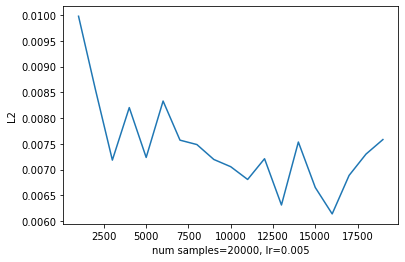

[0.009976278188813012, 0.008551103154662997, 0.007183376063252126, 0.008202704664610792, 0.007235169234241766, 0.008330182728357612, 0.007570643162296619, 0.0074852041247067975, 0.007196002898763254, 0.007055303443907178, 0.006807594303681981, 0.007210390221414855, 0.006312109357222653, 0.007534344351035543, 0.006651949443097692, 0.006138835237434251, 0.006886298633424303, 0.007300164167425465, 0.007582454760849942]


In [14]:
import matplotlib.pyplot as plt
loss_vals_x = np.arange(FLAGS.batch_size*100, train_sample_size, FLAGS.batch_size*100)
plt.plot(loss_vals_x, loss_vals)
plt.xlabel('num samples={}, lr={}'.format(train_sample_size, lr))
plt.ylabel('L2')
plt.show()
print(loss_vals)

In [15]:
# test: show imgs 
# Need work:
# saver.restore(sess, "./out/argminW/zoom_NoAug_l2_lr0.005/output/model_20000.ckpt")

[0.5        0.55555556 0.625      0.71428571 0.83333333 1.
 1.2        1.4        1.6        1.8        2.        ]


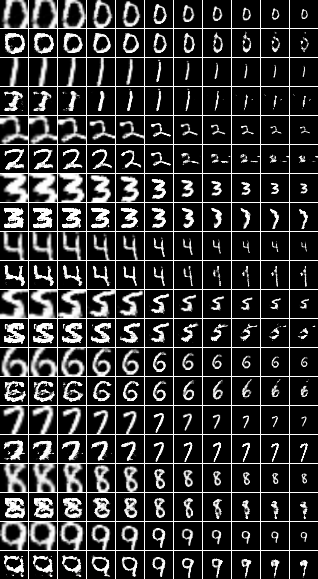

In [16]:
num_samples = 10

a = np.array([1.2, 1.4, 1.6, 1.8, 2.])
np.reciprocal(a[::-1])
b=[np.reciprocal(a[::-1]),np.array([1]),a]
a = np.concatenate(b)

zs = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
ys = np.zeros((num_samples, FLAGS.y_dim))
ys[np.arange(num_samples), y] = 1

im_targets = []
im_transformed = []
for i in range(a.shape[0]):
    feed_dict_out = {z_placeholder: zs, y_placeholder: ys}
    out_zs = sess.run(outputs_orig, feed_dict_out)
    target_fn, mask_out = get_target_np(out_zs, a[i])#, show_img=True, show_mask=True)
    im_targets.append(target_fn)
    ## get transformed:
    feed_dict = {z_placeholder: zs, y_placeholder: ys, alpha: a[i], target: target_fn, mask: mask_out}
    samples = sess.run(transformed_output, feed_dict=feed_dict)
    im_transformed.append(samples)
#     imshow(imgrid(np.uint8(samples*255), cols=1))

ims = []
for j in range(FLAGS.y_dim):
    ims.append(np.stack([x[j, :, :, :] for x in im_targets], axis=0))
    ims.append(np.stack([x[j, :, :, :] for x in im_transformed], axis=0))

print(a)
imshow(imgrid(np.uint8(np.concatenate(ims)*255), cols=a.shape[0]))

In [17]:
loss_l2_sample = tf.reduce_sum(tf.multiply(tf.square(transformed_output-target), mask), axis=(1,2,3)) \
        / tf.reduce_sum(mask, axis=(1,2,3))

loss_l2_trained = loss

In [18]:
import logging
import sys
# import argparse
# from utils import *
# import graphs
# import constants
import time
import pdb
import os
# import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 14})
rc('text', usetex=True)

num_samples = 200
vocab_size = FLAGS.y_dim
batch_size = FLAGS.batch_size

z_sample = np.random.uniform(-1, 1, size=(num_samples, FLAGS.z_dim))
y = np.arange(0,FLAGS.y_dim,1)
y_one_hot = np.zeros((len(y), FLAGS.y_dim))
y_one_hot[np.arange(len(y)), y] = 1
y_one_hot = np.tile(y_one_hot,[num_samples,1])

zs = z_sample
ys = y_one_hot
alphas = a 
alphas_no_log = a

# get alphas list
# if type(g) == graphs.ZoomTransform:
#     alp = np.linspace(1, opt.max_alpha, opt.num_alphas//2 + 1)
#     b = 1/alp
#     alphas = np.concatenate((np.delete(b[::-1], -1), alp), axis=0)
#     alphas = alphas[::-1]
# else:
#     alphas = np.linspace(-opt.max_alpha, opt.max_alpha, opt.num_alphas)
ylabel = 'L2 Distance'
dist_tensor = loss_l2_sample
dist_trained_tensor = loss_l2_trained
# dist_info = compute_transform_similarity(...)
# plot_similarity(dist_info...)

# # if opt.distance == 'l2':
# #     ylabel = 'L2 Distance'
# #     dist_tensor = g.loss_l2_sample
# # elif opt.distance == 'lpips':
# #     ylabel = 'Perceptual Distance'
# #     dist_tensor = g.loss_lpips_sample
# dist_info = compute_transform_similarity(ys, zs, alphas, dist_tensor)
# plot_similarity(alphas, dist_info, ylabel, output_dir, 'category_all')
# # if opt.category:
# #     for c in opt.category:
# #         ys = [c] * num_samples
# #         ys = one_hot_if_needed(ys, vocab_size)
# #         dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                                  dist_tensor)
# #         plot_similarity(alphas, dist_info, ylabel,
# #                         output_dir, 'category_{}'.format(c))
# # else:
# #     categories = np.random.randint(0, vocab_size, size=num_samples)
# #     ys = one_hot_if_needed(categories, vocab_size)
# #     dist_info = compute_transform_similarity(g, ys, zs, alphas,
# #                                              dist_tensor)
# #     plot_similarity(alphas, dist_info, ylabel, output_dir,
# #                     'category_all')

In [19]:
def scale_test_alpha_for_graph(alpha, zs_batch):
#     alpha = np.log(alpha) # only for zoom
    batch_size = zs_batch.shape[0]
    slider = alpha * np.ones((batch_size, Nsliders))
    return slider

In [20]:
dist_info = np.empty((num_samples, len(alphas) - 1))
dist_trained_info = np.empty((num_samples, len(alphas)))

for batch_start in range(0, num_samples, batch_size):
    s = slice(batch_start, min(num_samples, batch_start + batch_size))
    ys_batch = ys[s]
    zs_batch = zs[s]
    im_buffer = None # save the first set of images, for consecutive diff
    for i, a in enumerate(alphas):
        slider = scale_test_alpha_for_graph(a, zs_batch)
        input_test = {y_placeholder: ys_batch,
                      z_placeholder: zs_batch,
                      alpha: slider}
        im_transform = sess.run(transformed_output, feed_dict=input_test)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
        if im_buffer is not None:
            feed_dict = {
                mask: np.ones_like(im_transform),
                transformed_output: im_transform,
                target: im_buffer
            }
            # compute consecutive lpips diffs
            dist_info[s, i-1] = sess.run(dist_tensor, feed_dict=feed_dict)
#             print('consecutive diffs:', sess.run(dist_tensor, feed_dict=feed_dict))
        im_buffer = im_transform
    
        ## now compute the loss of train:
        ## already have im_transform, so get target and mask from G(a=0,z)
        out_zs = sess.run(outputs_orig, feed_dict_out)
        target_out, mask_out = get_target_np(out_zs, a)
#         imshow(imgrid(np.uint8(im_transform*255), cols=1))
#         imshow(imgrid(np.uint8(target_out*255), cols=1))
#         imshow(imgrid(np.uint8(mask_out*255), cols=1))
        feed_dict = {
            mask: mask_out,
            transformed_output: im_transform,
            target: target_out
        }
        dist_trained_info[s, i] = sess.run(dist_trained_tensor, feed_dict=feed_dict)

alpha: -0.64, dist 0.01 +/- 0.01
alpha: -0.53, dist 0.02 +/- 0.01
alpha: -0.40, dist 0.02 +/- 0.01
alpha: -0.26, dist 0.03 +/- 0.01
alpha: -0.09, dist 0.04 +/- 0.02
alpha: 0.09, dist 0.03 +/- 0.02
alpha: 0.26, dist 0.02 +/- 0.01
alpha: 0.40, dist 0.01 +/- 0.01
alpha: 0.53, dist 0.01 +/- 0.01
alpha: 0.64, dist 0.00 +/- 0.00
2019-09-12 15:54:37,459 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.
2019-09-12 15:54:37,460 [MainThread  ] [INFO ]  No LaTeX-compatible font found for the serif font family in rcParams. Using default.


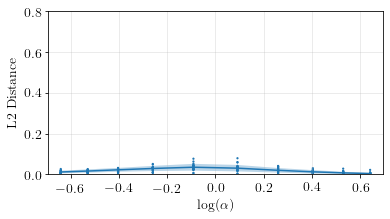

In [21]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_NoAug_argminW_transform_effect_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
mu = np.mean(dist_info, axis=0)
sd = np.std(dist_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)

alpha: -0.69, dist 0.26 +/- 0.01
alpha: -0.59, dist 0.25 +/- 0.01
alpha: -0.47, dist 0.22 +/- 0.01
alpha: -0.34, dist 0.16 +/- 0.01
alpha: -0.18, dist 0.13 +/- 0.01
alpha: 0.00, dist 0.09 +/- 0.01
alpha: 0.18, dist 0.09 +/- 0.01
alpha: 0.34, dist 0.11 +/- 0.01
alpha: 0.47, dist 0.11 +/- 0.01
alpha: 0.59, dist 0.12 +/- 0.01
alpha: 0.69, dist 0.13 +/- 0.01


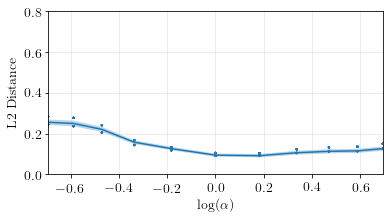

In [22]:
## plots and saves the computed similarity matrix
import os
output_dir = './out/transform_effect_plots/'
savefile = 'zoom_NoAug_argminW_loss_trained_plots'

alphas = alphas_no_log

xlabel = r'$\alpha$'
if np.min(alphas) > 0:
    alphas = np.log(alphas)
    xlabel = r'$\log(\alpha)$'
    
f, ax = plt.subplots(figsize=(6, 3))
# xaxis = np.mean([alphas[:-1], alphas[1:]], axis=0)
xaxis = np.mean([alphas[:], alphas[:]], axis=0)
mu = np.mean(dist_trained_info, axis=0)
sd = np.std(dist_trained_info, axis=0)
p = ax.plot(xaxis, mu)
ax.fill_between(xaxis, mu-sd, mu+sd, alpha=0.3)
xscatter = np.tile(xaxis, (20, 1))
yscatter = dist_trained_info[:20] # take the first 20 samples
ax.scatter(xscatter, yscatter, marker='.',
           edgecolors='none', s=20, color=p[0].get_color())
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

ax.set_ylim([0, 0.8])
ax.grid(alpha=0.3)
# ax.set_xlim([np.min(alphas), np.max(alphas)])
ax.set_xlim([np.min(alphas), np.max(alphas)])

for (x, m, s) in zip(xaxis, mu, sd):
    print("alpha: {:.2f}, dist {:.2f} +/- {:.2f}".format(x, m, s))

f.savefig(os.path.join(output_dir, savefile + '.png'),
          bbox_inches="tight", pad_inches=0)
f.savefig(os.path.join(output_dir, savefile + '.pdf'),
          bbox_inches="tight", pad_inches=0)